#### Guia: https://sanjayasubedi.com.np/nlp/nlp-with-python-document-clustering/

In [6]:
import pandas as pd
import numpy as np
import unidecode
#import mysql.connector
import re
import xlsxwriter
import datetime
from datetime import date

import nltk
from nltk.corpus import words

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [7]:
nltk.download('words')
nltk.download('wordnet')
nltk.download('stopwords')

stopwords = set(nltk.corpus.stopwords.words('spanish'))
include_stopwords = {'mas', 'menos', 'null', 'none'}
stopwords |= include_stopwords
print("Total spanish stopwords: {}\n".format(len(stopwords)))
stopwords_en = set(nltk.corpus.stopwords.words('english'))
print("Total english stopwords: {}\n".format(len(stopwords_en)))

Total spanish stopwords: 317

Total english stopwords: 179



[nltk_data] Downloading package words to C:\Users\Cristian
[nltk_data]     Restrepo\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Cristian
[nltk_data]     Restrepo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Cristian
[nltk_data]     Restrepo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
#Funciones para normalizar y tokenizar las palabras

#función para decodificar texto
def deco(text):
    if text is None :
        pass
    else:
        text = text.decode('unicode_escape').encode('iso8859-1').decode('utf8')
    return text

def clean_skills(text):
  text = re.sub('\"', '', text)
  text = re.sub('\}', '', text)
  text = re.sub(re.compile("{..: "),  '',    text)
  
  return text

def tokenize(text):
 #Remove text in square brackets, remove punctuation and remove words containing numbers.
 text = re.sub('\[.*?¿\]\%', ' ', text)
 text = re.sub('https://', '', text)
 text = re.sub('www.', '', text)
 text = re.sub('[‘’“”…«»]', '', text)
 text = re.sub(r'["\[\]\{\}\¿]', '', text)
 text = re.sub(r'_', ' ', text) 
 #text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
 text = re.sub('\w*\d\w*', '', text)
 text = re.sub(r'b‘\‘', '', text)

 text = re.sub('\n', ' ', text)
 text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
 
 #eliminar caracteres que se repitan más de dos veces seguidas
 pattern = re.compile(r"(.)\1{2,}")
 text =pattern.sub(r"\1\1", text) 
 
 return text.split()
 
def remove_stop(tokens):
  #stopwords = ['de','para']
  return [t for t in tokens if t.lower() not in stopwords]

def remove_stop_en(tokens):
  #stopwords = ['de','para']
  return [t for t in tokens if t.lower() not in stopwords_en]
 
#def lemmatize(text):
# prueba = nlp(text)
# tokens = [word.lemma_ for word in prueba]
# return tokens
 
#def join(tokens):
# sentence = (" ").join(tokens)
# return sentence
 
pipeline = [str.lower,tokenize, remove_stop, remove_stop_en]
 
 
def prepare(text, pipeline):
  tokens = text
  for transform in pipeline:
    tokens = transform(tokens)
  return ' '.join(tokens)

In [9]:
df = pd.read_excel('vacantes.xlsx')
df

,Id_vacante,Cargo,Descripcion,Habilidades,Nivel experiencia,Tipo empleo,# Solicitudes,Empresa,Sector,Fecha publicacion,Ubicacion,Ciudad,Pais,url_vacante
0,6530d8f07f4066b3bc1cb9da311ccafb,Desarrollador Java Angular,IntroducciónConduzca a IBM hacia el futuro tra...,NaN,No corresponde,FULL_TIME,NaN,IBM,Equipos informáticos,2021-05-06T06:24:21.000Z,"Bogotá, Distrito Capital, Colombia",Bogotá,CO,https://co.linkedin.com/jobs/view/desarrollado...
1,ZENDUSR14363EXTERNALENUS,Senior Staff Software Engineer,Job DescriptionZendesk is a service-first CRM ...,NaN,No corresponde,FULL_TIME,NaN,Zendesk,"Software,Servicios y tecnologías de la informa...",2021-05-06T06:17:46.000Z,Colombia,NaN,CO,https://co.linkedin.com/jobs/view/senior-staff...
2,743999745774408,Pricing Coordinator,"Job DescriptionPricing Coordinator, FinanceAbo...",NaN,Algo de responsabilidad,FULL_TIME,NaN,NielsenIQ,"Marketing y publicidad,Artículos de consumo,Ve...",2021-05-06T06:15:29.000Z,"Bogotá, Distrito Capital, Colombia",Bogotá,CO,https://co.linkedin.com/jobs/view/pricing-coor...
3,DANAGLOBALR1155363,Ingeniero de servicio,Ingeniero Químico o Químico Industrial o Quími...,NaN,No corresponde,FULL_TIME,NaN,ChemTreat,Servicios medioambientales,2021-05-06T06:11:09.000Z,"Tocancipá, Cundinamarca, Colombia",Sopó,CO,https://co.linkedin.com/jobs/view/ingeniero-de...
4,29819,Principal Consultant - Colombia,Description And RequirementsFrom core to cloud...,NaN,No corresponde,FULL_TIME,NaN,BMC Software,"Equipos informáticos,Software,Servicios y tecn...",2021-05-06T06:09:02.000Z,Área metropolitana de Bogotá D.C.,Bogotá,CO,https://co.linkedin.com/jobs/view/principal-co...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,194953,Registered Nurse House Supervisor,"House Supervisors address staffing, patient ca...",NaN,Sin experiencia,TEMPORARY,NaN,Stability Healthcare,"Atención sanitaria y hospitalaria,Dotación y s...",2021-05-06T04:31:55.000Z,"Casanare, Colombia",Yopal,CO,https://co.linkedin.com/jobs/view/registered-n...
146,NaN,Servicio técnico celulares,"Técnico en celulares y tabletas, corrección de...",NaN,NaN,FULL_TIME,NaN,Movilya,NaN,2021-05-06T04:29:55.000Z,"Bogotá, Distrito Capital, Colombia",Bogotá,CO,https://co.linkedin.com/jobs/view/servicio-t%C...
147,NaN,Experto en Marketing y Monetización,Experto en Marketing y Monetización.Actualment...,NaN,NaN,FULL_TIME,NaN,PUBLIANAGRAMA SL,NaN,2021-05-06T04:25:46.000Z,Colombia,NaN,CO,https://co.linkedin.com/jobs/view/experto-en-m...
148,NaN,Sales Manager Colombia,Octopus Digital Group is the Digital Advertisi...,NaN,NaN,FULL_TIME,"<span class=""topcard__flavor--metadata topcard...",Octopus Digital Group,NaN,2021-05-06T04:22:52.000Z,"Bogotá, Distrito Capital, Colombia",Bogotá,CO,https://co.linkedin.com/jobs/view/sales-manage...


In [12]:
df_prueba = df[['Cargo']].copy()
df_prueba.reset_index(inplace=True)
df_prueba

,index,Cargo
0,0,Desarrollador Java Angular
1,1,Senior Staff Software Engineer
2,2,Pricing Coordinator
3,3,Ingeniero de servicio
4,4,Principal Consultant - Colombia
...,...,...
145,145,Registered Nurse House Supervisor
146,146,Servicio técnico celulares
147,147,Experto en Marketing y Monetización
148,148,Sales Manager Colombia


In [14]:
df_prueba['Cargo'] = df_prueba['Cargo'].apply(lambda x: prepare(x, pipeline))
df_prueba['Cargo1'] = df_prueba['Cargo'].apply(lambda x: 1 if detect(x) == 'en' else 0)
#translator = Translator()
#df['Cargo1'] = df['Cargo'].apply(translator.translate, src='es', dest='en')
df_prueba

,index,Cargo,Cargo1
0,0,desarrollador java angular,0
1,1,senior staff software engineer,1
2,2,pricing coordinator,0
3,3,ingeniero servicio,0
4,4,principal consultant - colombia,0
...,...,...,...
145,145,registered nurse house supervisor,1
146,146,servicio técnico celulares,0
147,147,experto marketing monetización,0
148,148,sales manager colombia,0


In [4]:
'''
>>> from langdetect import detect
>>> detect("War doesn't show who's right, just who's left.")
'en'
>>> detect("Ein, zwei, drei, vier")
'de'

from googletrans import Translator
translator = Translator()
df['English'] = df['Review to Translate'].apply(translator.translate, src='id', dest='en')

! pip install googletrans
from googletrans import Translator
import pandas as pd
translator = Translator()
df = pd.DataFrame({'Spanish':['piso','cama']})
df['English'] = df['Spanish'].apply(translator.translate, src='es', dest='en').apply(getattr, args=('text',))
df

Verify: https://stackoverflow.com/questions/52455774/googletrans-stopped-working-with-error-nonetype-object-has-no-attribute-group
'''
!pip install langdetect
from langdetect import detect
detect("War doesn't show who's right, just who's left.")

  Created wheel for langdetect: filename=langdetect-1.0.8-py3-none-any.whl size=993196 sha256=d360ae6ee17fd9f0e610b2ab7dab6846ff1991ae9a32f982aa25f464a9ec9e6f
  Stored in directory: c:\users\cristian restrepo\appdata\local\pip\cache\wheels\59\f6\9d\85068904dba861c0b9af74e286265a08da438748ee5ae56067
Successfully built langdetect


'en'

In [30]:
vec = TfidfVectorizer(stop_words="english")
vec.fit(df_prueba.Cargo.values)
features = vec.transform(df.Cargo.values)

In [31]:
# for reproducibility
random_state = 0 
cls = MiniBatchKMeans(n_clusters=10, random_state=random_state)
cls.fit(features)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=0,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [32]:
cls.predict(features)

array([2, 0, 2, 2, 1, 0, 7, 7, 8, 8, 8, 5, 0, 2, 7, 3, 4, 0, 0, 0, 6, 9,
       3, 6, 0, 0, 1, 7, 7, 8, 8, 8, 5, 0, 2, 7, 3, 4, 0, 0, 0, 6, 9, 4,
       0, 6, 3, 6, 6, 6, 0, 2, 2, 1, 0, 7, 7, 8, 8, 8, 5, 0, 2, 7, 3, 4,
       0, 0, 0, 6, 9, 3, 6, 0, 6, 0, 2, 2, 2, 1, 0, 7, 7, 8, 8, 8, 5, 0,
       2, 7, 3, 4, 0, 0, 0, 6, 9, 3, 6, 0, 0, 2, 2, 2, 1, 0, 7, 7, 8, 8,
       8, 5, 0, 2, 7, 3, 4, 0, 0, 0, 6, 9, 3, 6, 0, 0, 1, 0, 7, 7, 8, 8,
       8, 5, 0, 2, 7, 3, 4, 0, 0, 0, 6, 9, 4, 6, 0, 6, 6, 6])

In [33]:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=random_state)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

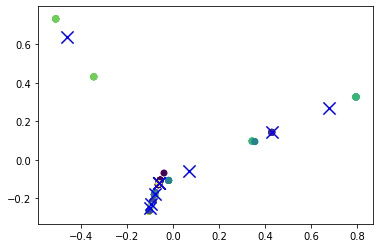

In [34]:
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')